In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import pandas as pd
from model_0 import *
# from model_1 import *

palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='whitegrid', font="cmr10", font_scale=1.0)
plt.rcParams['axes.formatter.use_mathtext'] = True

In [2]:
def plot_network(net, bid, trials=10):
    dfs = []
    columns = ['sid', 'bid', 'trial', 'value A', 'value B', 'value L', 'value R',
               'omega', 'omega target', 'reward L', 'reward R', 'total L', 'total R', 'action L', 'action R']
              # 'error A', 'error B', 'error L', 'error R']
    sim = nengo.Simulator(net, dt=net.env.dt, progress_bar=False)    
    with sim:
        sim.run(net.env.t_load)
        for trial in net.env.empirical.query("sid==@sid & bid==@bid")['trial'].unique()[:trials]:
            print(f"running sid {net.env.sid}, block {bid}, trial {trial}")
            net.env.set_cue(bid, trial)
            sim.run(net.env.t_cue)
            env.set_action(sim, net)
            env.set_omega(sim, net)
            env.set_reward(bid, trial)
            if sim.data[net.p_letter][-1,0]>sim.data[net.p_letter][-1,1]:
                value_B, value_A = sim.data[net.p_value_letter][-1,0], sim.data[net.p_value_letter][-1,1]
            else:
                value_A, value_B = sim.data[net.p_value_letter][-1,0], sim.data[net.p_value_letter][-1,1]
            value_L, value_R = sim.data[net.p_value_location][-1,0], sim.data[net.p_value_location][-1,1]
            omega = sim.data[net.p_omega][-1,0]
            omega_target = sim.data[net.p_omega_target][-1,0]
            reward_L, reward_R = env.reward[0], env.reward[1]
            total_L, total_R = sim.data[net.p_value_left][-1,0], sim.data[net.p_value_right][-1,0]                
            action_L, action_R = env.action[0], env.action[1]
            df = pd.DataFrame([[sid, bid, trial, value_A, value_B, value_L, value_R, omega, omega_target,
                                reward_L, reward_R, total_L, total_R, action_L, action_R]], columns=columns)
                                # error_A, error_B, error_loc_L, error_loc_R]], columns=columns)
            dfs.append(df)
            sim.run(net.env.t_reward)
            # error_letter_L, error_letter_R, error_loc_L, error_loc_R = -sim.data[net.p_error_decode][-1]
            # if sim.data[net.p_letter][-1,0]<sim.data[net.p_letter][-1,1]:
            #     error_A, error_B = error_letter_L, error_letter_R
            # else:
            #     error_B, error_A = error_letter_L, error_letter_R
            # df = pd.DataFrame([[sid, bid, trial, value_A, value_B, value_L, value_R, omega, omega_target,
            #                     reward_L, reward_R, total_L, total_R, action_L, action_R,
            #                     error_letter_L, error_letter_R, error_loc_L, error_loc_R]], columns=columns)
    data = pd.concat(dfs, ignore_index=True)
    return sim, data

## Dynamics

In [3]:
sid = 1
trials = 10
bid_what = 5
bid_where = 15

In [4]:
env = Environment(sid=sid)
net_what = build_network(env)
sim_what, data_what = plot_network(net_what, bid=bid_what, trials=trials)

running sid 1, block 5, trial 1
running sid 1, block 5, trial 2
running sid 1, block 5, trial 3
running sid 1, block 5, trial 4
running sid 1, block 5, trial 5
running sid 1, block 5, trial 6
running sid 1, block 5, trial 7
running sid 1, block 5, trial 8
running sid 1, block 5, trial 9
running sid 1, block 5, trial 10


In [20]:
env = Environment(sid=sid)
net_where = build_network(env)
sim_where, data_where = plot_network(net_where, bid=bid_where, trials=trials)

running sid 1, block 15, trial 1
running sid 1, block 15, trial 2
running sid 1, block 15, trial 3
running sid 1, block 15, trial 4
running sid 1, block 15, trial 5
running sid 1, block 15, trial 6
running sid 1, block 15, trial 7
running sid 1, block 15, trial 8
running sid 1, block 15, trial 9
running sid 1, block 15, trial 10


In [5]:
def make_plot(data, bid, trials=80):
    fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(14, 4))
    sns.lineplot(data, x='trial', y='value A', ax=axes[0], color=palette[0], label='A')
    sns.lineplot(data, x='trial', y='value B', ax=axes[0], color=palette[1], label='B')
    sns.lineplot(data, x='trial', y='value L', ax=axes[1], color=palette[0], label='L')
    sns.lineplot(data, x='trial', y='value R', ax=axes[1], color=palette[1], label='R')
    sns.lineplot(data, x='trial', y='omega', ax=axes[2], color=palette[0], label=r'$\omega$')
    sns.lineplot(data, x='trial', y='omega target', ax=axes[2], color=palette[1], label='target')
    sns.lineplot(data, x='trial', y='total L', ax=axes[3], color=palette[0], label='L')
    sns.lineplot(data, x='trial', y='total R', ax=axes[3], color=palette[1], label='R')
    sns.lineplot(data, x='trial', y='reward L', ax=axes[4], color=palette[0], label='L')
    sns.lineplot(data, x='trial', y='reward R', ax=axes[4], color=palette[1], label='R')
    # sns.lineplot(data, x='trial', y='error A', ax=axes[5], color=palette[0], label='letter A')
    # sns.lineplot(data, x='trial', y='error B', ax=axes[5], color=palette[1], label='letter B')
    # sns.lineplot(data, x='trial', y='error L', ax=axes[5], color=palette[2], label='loc L')
    # sns.lineplot(data, x='trial', y='error R', ax=axes[5], color=palette[3], label='loc R')
    if trials>40:
        reversal_at_trial = env.empirical.query("sid==@sid & bid==@bid")['reversal_at_trial'].unique()[0]
        axes[0].axvline(reversal_at_trial, color=palette[2])
        axes[1].axvline(reversal_at_trial, color=palette[2])
        axes[2].axvline(reversal_at_trial, color=palette[2])
        axes[3].axvline(reversal_at_trial, color=palette[2])
        axes[4].axvline(reversal_at_trial, color=palette[2])
        # axes[5].axvline(reversal_at_trial, color=palette[2])
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()
    axes[3].legend()
    axes[4].legend()
    # axes[5].legend()
    axes[0].set(title="Letter Value", xlim=(1, trials), ylim=(-1.1,1.1))
    axes[1].set(title="Location Value")
    axes[2].set(title="Omega")
    axes[3].set(title="Total Weighted Value")
    axes[4].set(title="Reward")
    # axes[5].set(title="Error")
    plt.tight_layout()

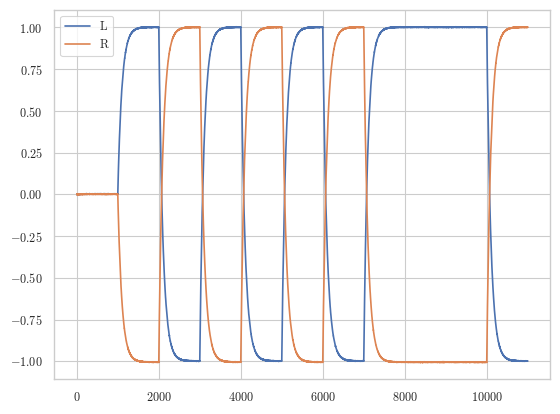

In [6]:
plt.plot(sim_what.data[net_what.p_letter][:,0], label='L')
plt.plot(sim_what.data[net_what.p_letter][:,1], label='R')
plt.legend()

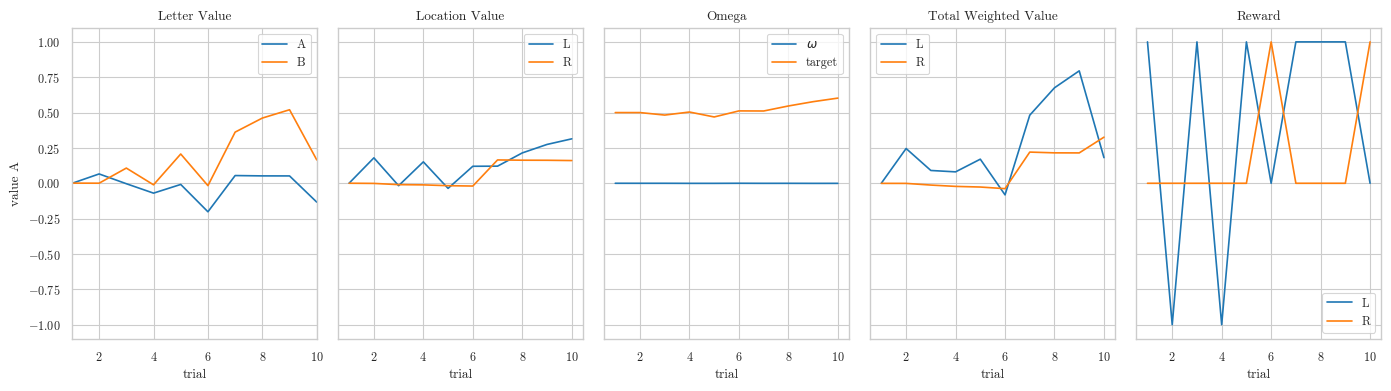

In [7]:
make_plot(data_what, bid=bid_what, trials=trials)

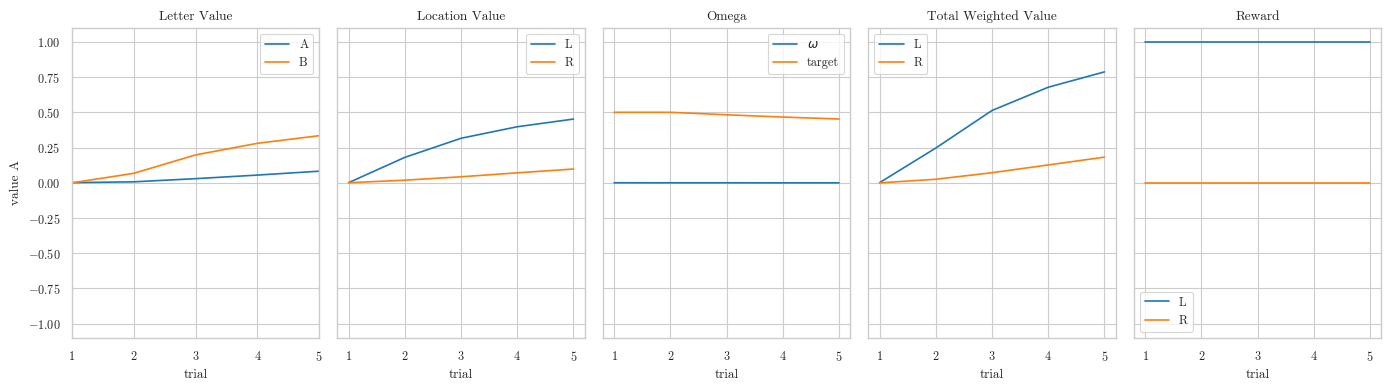

In [8]:
make_plot(data_where, bid=bid_where, trials=trials)

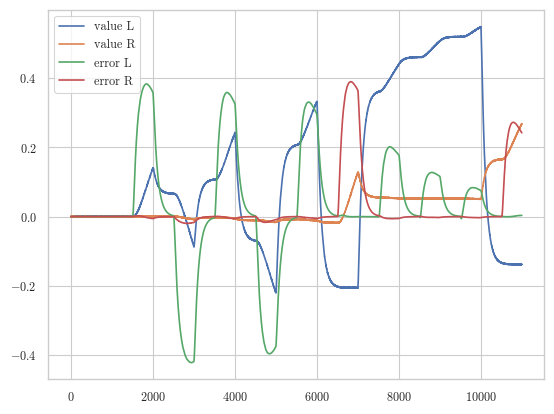

In [8]:
plt.plot(sim_what.data[net_what.p_value_letter][:,0], label='value L')
plt.plot(sim_what.data[net_what.p_value_letter][:,1], label='value R')
plt.plot(-sim_what.data[net_what.p_error_decode][:,0], label='error L')
plt.plot(-sim_what.data[net_what.p_error_decode][:,1], label='error R')
plt.legend()

## Simulate all behavioral data

In [17]:
empirical = pd.read_pickle("data/empirical.pkl")
dfs = []
# for sid in empirical['sid'].unique():
for sid in [0]:
    env = Environment(sid=sid)
    net = build_network(env)
    sim, data = simulate_network(net)
    dfs.append(data)
simulated = pd.concat(dfs, ignore_index=True)
# simulated.to_pickle("data/simulated.pkl")

running sid 0, block 19, trial 1
running sid 0, block 19, trial 2
running sid 0, block 19, trial 3
running sid 0, block 19, trial 4
running sid 0, block 19, trial 5
running sid 0, block 19, trial 6
running sid 0, block 19, trial 7
running sid 0, block 19, trial 8
running sid 0, block 19, trial 9
running sid 0, block 19, trial 10
running sid 0, block 19, trial 11
running sid 0, block 19, trial 12
running sid 0, block 19, trial 13
running sid 0, block 19, trial 14
running sid 0, block 19, trial 15
running sid 0, block 19, trial 16
running sid 0, block 19, trial 17
running sid 0, block 19, trial 18
running sid 0, block 19, trial 19
running sid 0, block 19, trial 20
running sid 0, block 19, trial 21
running sid 0, block 19, trial 22
running sid 0, block 19, trial 23
running sid 0, block 19, trial 24
running sid 0, block 19, trial 25
running sid 0, block 19, trial 26
running sid 0, block 19, trial 27
running sid 0, block 19, trial 28
running sid 0, block 19, trial 29
running sid 0, block 19

## Load

In [15]:
# empirical = pd.read_pickle("data/empirical.pkl")
# dfs = []
# for sid in empirical['sid'].unique():
#     data = pd.read_pickle(f"data/reward1/model0_sid{sid}_behavior.pkl")
#     dfs.append(data)
# simulated = pd.concat(dfs, ignore_index=True)
# simulated.to_pickle("data/simulated.pkl")

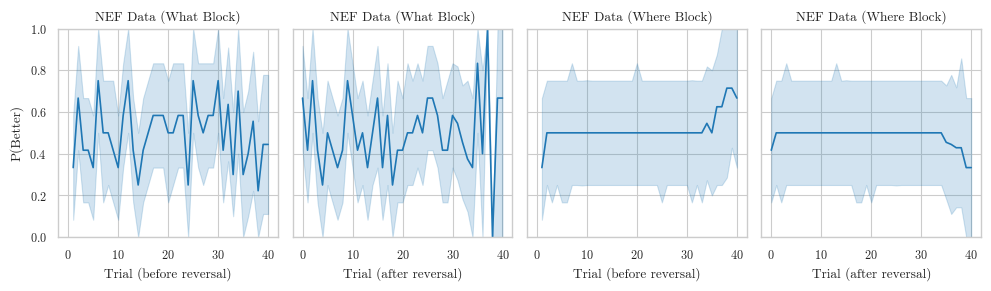

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(10, 3))
sns.lineplot(simulated.query("bid<13 & trial_before_reversal<=40"), x='trial_before_reversal', y='accuracy', color=palette[0], ax=axes[0])
sns.lineplot(simulated.query("bid<13 & trial_after_reversal<=40"), x='trial_after_reversal', y='accuracy', color=palette[0], ax=axes[1])
sns.lineplot(simulated.query("bid>=13 & trial_before_reversal<=40"), x='trial_before_reversal', y='accuracy', color=palette[0], ax=axes[2])
sns.lineplot(simulated.query("bid>=13 & trial_after_reversal<=40"), x='trial_after_reversal', y='accuracy', color=palette[0], ax=axes[3])
axes[0].set(ylabel="P(Better)", xlabel='Trial (before reversal)', title='NEF Data (What Block)', ylim=(0, 1))
axes[1].set(xlabel='Trial (after reversal)', title='NEF Data (What Block)')
axes[2].set(xlabel='Trial (before reversal)', title='NEF Data (Where Block)')
axes[3].set(xlabel='Trial (after reversal)', title='NEF Data (Where Block)')
fig.tight_layout()

## Compare to monkey accuracy

In [8]:
# def monkey_trends():
#     dfs = []
#     columns = ['sid', 'bid', 'trial_before_reversal', 'trial_after_reversal', 'accuracy']
#     empirical = pd.read_pickle("data/empirical.pkl")
#     for sid in empirical['sid'].unique():
#         for bid in empirical.query("sid==@sid")['bid'].unique():
#             print(sid, bid)
#             for trial in empirical.query("sid==@sid & bid==@bid")['trial'].unique():
#                 reversal_at_trial = empirical.query("sid==@sid & bid==@bid")['reversal_at_trial'].unique()[0]
#                 accuracy = empirical.query("sid==@sid & bid==@bid & trial==@trial")['monkey_accuracy'].unique()[0]
#                 trial_before_reversal = trial if trial<reversal_at_trial else None
#                 trial_after_reversal = trial - reversal_at_trial if trial>=reversal_at_trial else None
#                 dfs.append(pd.DataFrame([[sid, bid, trial_before_reversal, trial_after_reversal, accuracy]], columns=columns))
#     data = pd.concat(dfs, ignore_index=True)
#     data.to_pickle("data/monkey_accuracy.pkl")
#     return data

In [9]:
# monkey_accuracy = monkey_trends()

In [10]:
# fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(10, 3))
# sns.lineplot(monkey_accuracy.query("bid<13 & trial_before_reversal<=40"), x='trial_before_reversal', y='accuracy', color=palette[0], ax=axes[0])
# sns.lineplot(monkey_accuracy.query("bid<13 & trial_after_reversal<=40"), x='trial_after_reversal', y='accuracy', color=palette[0], ax=axes[1])
# sns.lineplot(monkey_accuracy.query("bid>=13 & trial_before_reversal<=40"), x='trial_before_reversal', y='accuracy', color=palette[0], ax=axes[2])
# sns.lineplot(monkey_accuracy.query("bid>=13 & trial_after_reversal<=40"), x='trial_after_reversal', y='accuracy', color=palette[0], ax=axes[3])
# axes[0].set(ylabel="P(Better)", xlabel='Trial (before reversal)', title='Monkey Data (What Block)', ylim=(0, 1))
# axes[1].set(xlabel='Trial (after reversal)', title='Monkey Data (What Block)')
# axes[2].set(xlabel='Trial (before reversal)', title='Monkey Data (Where Block)')
# axes[3].set(xlabel='Trial (after reversal)', title='Monkey Data (Where Block)')
# fig.tight_layout()

## Combined Plot

In [17]:
monkey_accuracy = pd.read_pickle("data/monkey_accuracy.pkl")
model_accuracy = pd.read_pickle("data/simulated.pkl")

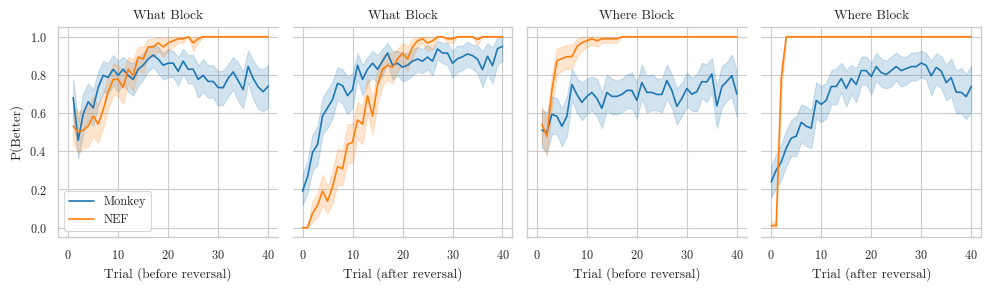

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(10, 3))
sns.lineplot(monkey_accuracy.query("bid<13 & trial_before_reversal<=40"), x='trial_before_reversal', y='accuracy', color=palette[0], ax=axes[0], label='Monkey')
sns.lineplot(monkey_accuracy.query("bid<13 & trial_after_reversal<=40"), x='trial_after_reversal', y='accuracy', color=palette[0], ax=axes[1])
sns.lineplot(monkey_accuracy.query("bid>=13 & trial_before_reversal<=40"), x='trial_before_reversal', y='accuracy', color=palette[0], ax=axes[2])
sns.lineplot(monkey_accuracy.query("bid>=13 & trial_after_reversal<=40"), x='trial_after_reversal', y='accuracy', color=palette[0], ax=axes[3])
sns.lineplot(model_accuracy.query("bid<13 & trial_before_reversal<=40"), x='trial_before_reversal', y='accuracy', color=palette[1], ax=axes[0], label='NEF')
sns.lineplot(model_accuracy.query("bid<13 & trial_after_reversal<=40"), x='trial_after_reversal', y='accuracy', color=palette[1], ax=axes[1])
sns.lineplot(model_accuracy.query("bid>=13 & trial_before_reversal<=40"), x='trial_before_reversal', y='accuracy', color=palette[1], ax=axes[2])
sns.lineplot(model_accuracy.query("bid>=13 & trial_after_reversal<=40"), x='trial_after_reversal', y='accuracy', color=palette[1], ax=axes[3])
axes[0].legend()
axes[0].set(ylabel="P(Better)", xlabel='Trial (before reversal)', title='What Block')
axes[1].set(xlabel='Trial (after reversal)', title='What Block')
axes[2].set(xlabel='Trial (before reversal)', title='Where Block')
axes[3].set(xlabel='Trial (after reversal)', title='Where Block')
axes[0].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[2].spines['right'].set_visible(False)
axes[3].spines['left'].set_visible(False)
fig.tight_layout()
fig.savefig("plots/model0_behavior.jpg", dpi=600)